<a href="https://colab.research.google.com/github/Ghassan1991/Amazon-Reviews-Analysis/blob/main/Data_Wrangling_and_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Package Installation Command


In [18]:
!pip install datasets pandas matplotlib  # Install essential data science libraries for Python

# Load the Amazon Reviews Data

In [19]:
# Import the load_dataset function from Hugging Face datasets library
# This function provides access to thousands of pre-processed datasets
from datasets import load_dataset
import pandas as pd

# Load a subset (e.g., 10,000 rows for speed)
ds = load_dataset("amazon_polarity", split="train[:10000]")
df = pd.DataFrame(ds)
df.head()


,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


# Basic EDA

In [20]:
print(df['label'].value_counts()) # Shows how many times each class/label appears in the dataset


label
0    5097
1    4903
Name: count, dtype: int64


In [21]:
print(df.isnull().sum()) # Prints the number of missing (NaN) values in each column of the DataFrame

label      0
title      0
content    0
dtype: int64


In [22]:
df[['label', 'title', 'content']].sample(5) # Randomly selects 5 rows from the specified columns for inspection


,label,title,content
6450,1,"Fly Boys Lafayette Escadrille,movie for Plane ...","The ""experts"" always!! This movie is enjoyable..."
4187,0,doesnt work,Put new batteries in - product wont turn on at...
7229,1,This book changed the way I look at all books.,Guy Montag is a fireman who job it is to start...
5847,1,"Exactly as described, 15 feet of stereo 3.5mm ...","Works as described, no distortion issues. I us..."
2316,1,Nightwish is unique and rocks for eva,"Moi to you all,Nightwish est vraiment le plus ..."


In [23]:
df['word_count'] = df['content'].apply(lambda x: len(x.split())) # Adds a new column with the number of words in each 'content'
df[['word_count']].describe() # Provides descriptive statistics (count, mean, std, etc.) for the 'word_count' column


,word_count
count,10000.000000
mean,75.228500
std,42.519171
min,7.000000
25%,40.000000
50%,66.000000
75%,104.000000
max,206.000000


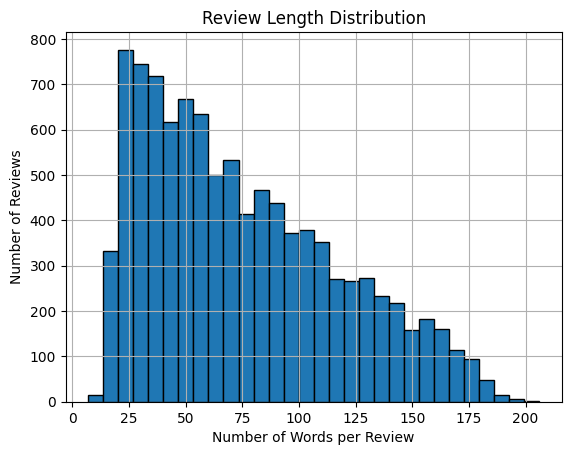

In [24]:
import matplotlib.pyplot as plt  # Imports the matplotlib library for plotting

df['word_count'].hist(bins=30, edgecolor='black')  # Plots a histogram of the 'word_count' column with 30 bins and black edges
plt.xlabel('Number of Words per Review')  # Sets the label for the x-axis
plt.ylabel('Number of Reviews')  # Sets the label for the y-axis
plt.title('Review Length Distribution')  # Sets the title of the plot
plt.show()  # Displays the histogram


In [25]:
from collections import Counter  # Imports Counter for counting hashable objects

all_words = ' '.join(df['content']).lower().split()  # Joins all content, lowercases, and splits into words
common_words = Counter(all_words).most_common(20)    # Counts and selects the 20 most common words
print("Top 20 words:", common_words)  # Prints the 20 most frequent words and their counts


Top 20 words: [('the', 38834), ('and', 20446), ('i', 19404), ('a', 19049), ('to', 18568), ('of', 15937), ('this', 14100), ('is', 13837), ('it', 13267), ('in', 9321), ('that', 7745), ('for', 7610), ('was', 7124), ('you', 5791), ('not', 5360), ('but', 5314), ('with', 5273), ('on', 5031), ('have', 4709), ('my', 4669)]


In [26]:
df.to_csv("amazon_reviews_raw.csv", index=False)  # Saves the DataFrame to a CSV file without row indices
from google.colab import files  # Imports Colab's files module for file operations
files.download("amazon_reviews_raw.csv")  # Downloads the saved CSV file to your local machine


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Preprocessing

In [27]:
# Step: Text Normalization - Convert all text to lowercase
df['clean_content'] = df['content'].str.lower()  # Converts all text in 'content' to lowercase and stores it in 'clean_content'


In [28]:
# Step: Text Cleaning - Remove punctuation from the text
import string  # Imports the string module, which includes a list of common punctuation characters
df['clean_content'] = df['clean_content'].str.translate(str.maketrans('', '', string.punctuation))  # Removes all punctuation from 'clean_content'


In [29]:
# Step: Text Cleaning - Remove numbers from the text
df['clean_content'] = df['clean_content'].str.replace(r'\d+', '', regex=True)  # Removes all numeric digits from 'clean_content'

# Step: Text Cleaning - Normalize whitespace
df['clean_content'] = df['clean_content'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Replaces multiple spaces with a single space and strips leading/trailing spaces


In [30]:
# Step: Install and set up NLTK stopwords
!pip install nltk  # Installs the Natural Language Toolkit (NLTK) library

import nltk  # Imports the NLTK library
nltk.download('stopwords')  # Downloads the list of stopwords for use in text preprocessing


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
# Step: Text Cleaning - Remove stopwords from the text
from nltk.corpus import stopwords  # Imports the stopwords list from NLTK
stop_words = set(stopwords.words('english'))  # Loads the set of English stopwords

def remove_stopwords(text):
    # Returns the text after removing stopwords
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_content'] = df['clean_content'].apply(remove_stopwords)  # Applies the function to remove stopwords from 'clean_content'



In [32]:
# Step: Install and download spaCy English model
!pip install spacy  # Installs the spaCy NLP library

!python -m spacy download en_core_web_sm  # Downloads the small English language model for spaCy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 120.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [33]:
# Step: Text Normalization - Lemmatization using spaCy
import spacy  # Imports the spaCy library for advanced NLP tasks
nlp = spacy.load("en_core_web_sm")  # Loads the small English spaCy model

def lemmatize(text):
    doc = nlp(text)  # Processes the text using spaCy NLP pipeline
    return ' '.join([token.lemma_ for token in doc])  # Joins the lemmatized tokens back into a single string

# Applies lemmatization to the first 1,000 rows of 'clean_content' for faster demonstration
df.loc[:999, 'clean_content'] = df.loc[:999, 'clean_content'].apply(lemmatize)


In [34]:
# Step: Data Filtering - Remove short reviews
df = df[df['clean_content'].str.split().str.len() > 3]  # Keeps only rows where 'clean_content' has more than 3 words
print("After removing short reviews:", df.shape)  # Prints the shape of the DataFrame after filtering


After removing short reviews: (9998, 5)


In [35]:
# Step: Data Inspection - Compare original and cleaned content
df[['content', 'clean_content']].sample(5)  # Randomly samples 5 rows to compare original and cleaned text


,content,clean_content
3440,The NBC coverage offered in these videos is fa...,nbc coverage offered videos fascinating watch ...
7120,This is a lovely erotic fantasy. There are gli...,lovely erotic fantasy glimpses bdsm hardcoredo...
2639,This is quite simply the worst story i have ev...,quite simply worst story ever read lifeit depr...
3458,With no harmful intentions toward the movie br...,harmful intentions toward movie brassed offtha...
588,"I ordered a 3X, because that's the size that t...",order x that s size website say order come lac...


In [36]:
# Step: Save and Download the Cleaned Data
df.to_csv("amazon_reviews_cleaned.csv", index=False)  # Saves the cleaned DataFrame to a CSV file without row indices
from google.colab import files  # Imports the files module for downloading in Google Colab
files.download("amazon_reviews_cleaned.csv")  # Downloads the cleaned CSV file to your local machine


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Data Splitting

In [37]:

from sklearn.model_selection import train_test_split  # Imports the function to split data for machine learning

X = df['clean_content']  # Features: the cleaned review text
y = df['label']  # Target labels (e.g., sentiment or category)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # Splits data into 80% train and 20% test sets with a fixed random seed for reproducibility


## Feature Extraction - Convert text to TF-IDF vectors

In [38]:

from sklearn.feature_extraction.text import TfidfVectorizer  # Imports the TF-IDF vectorizer for text feature extraction

vectorizer = TfidfVectorizer(max_features=5000)  # Initializes the vectorizer to use the top 5,000 terms by frequency
X_train_vec = vectorizer.fit_transform(X_train)  # Fits the vectorizer on the training text and transforms it into TF-IDF features
X_test_vec = vectorizer.transform(X_test)  # Transforms the test text into TF-IDF features using the same vectorizer


## Model Training - Fit a Logistic Regression classifier

In [39]:

from sklearn.linear_model import LogisticRegression  # Imports the Logistic Regression model

clf = LogisticRegression(max_iter=200)  # Creates a Logistic Regression classifier with up to 200 iterations
clf.fit(X_train_vec, y_train)  # Trains the classifier on the TF-IDF feature vectors and labels


LogisticRegression(max_iter=200)

## Model Evaluation - Evaluate the performance of the classifier

In [40]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Imports metrics for evaluation

y_pred = clf.predict(X_test_vec)  # Predicts the labels for the test set

print("Accuracy:", accuracy_score(y_test, y_pred))  # Prints the overall accuracy of the model
print("Classification Report:\n", classification_report(y_test, y_pred))  # Prints precision, recall, f1-score, and support for each class
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # Prints the confusion matrix to show correct and incorrect predictions


Accuracy: 0.8345
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1024
           1       0.84      0.82      0.83       976

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Confusion Matrix:
 [[872 152]
 [179 797]]


## Model Saving and Download - Save the trained model and vectorizer, then download them

In [41]:

import joblib  # Imports joblib for saving (serializing) Python objects

joblib.dump(clf, "logreg_model.joblib")  # Saves the trained Logistic Regression model to a file
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")  # Saves the fitted TF-IDF vectorizer to a file

from google.colab import files  # Imports Colab's files module for downloading
files.download("logreg_model.joblib")  # Downloads the saved model file
files.download("tfidf_vectorizer.joblib")  # Downloads the saved vectorizer file



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization - Plot the confusion matrix as a heatmap

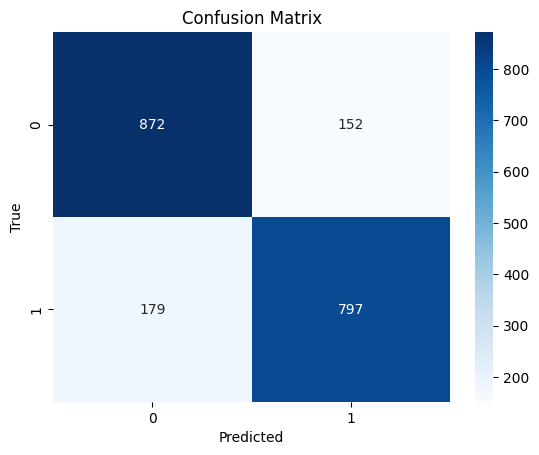

In [42]:

import seaborn as sns  # Imports seaborn for statistical data visualization
import matplotlib.pyplot as plt  # Imports matplotlib for plotting

cm = confusion_matrix(y_test, y_pred)  # Computes the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plots the confusion matrix as a heatmap with annotations
plt.xlabel('Predicted')  # Label for x-axis
plt.ylabel('True')  # Label for y-axis
plt.title('Confusion Matrix')  # Title for the plot
plt.show()  # Displays the plot


In [43]:

!pip install transformers datasets scikit-learn  # Installs the Hugging Face Transformers library, Datasets library, and scikit-learn for ML tasks



In [44]:
# Step: Data Upload - Upload files from your local machine to Colab
from google.colab import files  # Imports Colab's files module for file operations
uploaded = files.upload()  # Opens a file dialog to upload files; stores uploaded files in a dictionary



Saving amazon_reviews_cleaned.csv to amazon_reviews_cleaned (1).csv


In [45]:
# Step: Data Loading and Cleaning - Load the CSV and drop missing values
import pandas as pd  # Imports pandas for data manipulation

df = pd.read_csv('/content/amazon_reviews_cleaned.csv')  # Loads the cleaned data from CSV into a DataFrame
df = df.dropna(subset=['clean_content', 'label'])  # Removes rows where 'clean_content' or 'label' is missing


In [46]:
df.head()

,label,title,content,word_count,clean_content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,75,sound track beautiful paint senery mind well w...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,91,I m read lot review say good game soundtrack f...
2,1,Amazing!,This soundtrack is my favorite music of all ti...,128,soundtrack favorite music time hand intense sa...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,116,truly like soundtrack enjoy video game music p...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",77,you ve play game know divine music every singl...


In [47]:
# Step: Data Formatting - Prepare DataFrame for NLP tasks
df = df.rename(columns={'clean_content': 'text'})  # Renames 'clean_content' column to 'text'
df = df[['text', 'label']]  # Selects only the 'text' and 'label' columns
df = df[df['text'].str.strip().astype(bool)]  # Removes rows where 'text' is empty or only whitespace


In [48]:
# Step: Data Inspection - View the first few rows of the DataFrame
df.head()  # Displays the first 5 rows of the DataFrame to inspect the data structure and values


,text,label
0,sound track beautiful paint senery mind well w...,1
1,I m read lot review say good game soundtrack f...,1
2,soundtrack favorite music time hand intense sa...,1
3,truly like soundtrack enjoy video game music p...,1
4,you ve play game know divine music every singl...,1


In [49]:
# Step: Data Splitting - Split data into training and validation sets for NLP modeling
from sklearn.model_selection import train_test_split  # Imports the function for splitting data

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),   # Converts the 'text' column to a list (for compatibility with Hugging Face or other libraries)
    df['label'].tolist(),  # Converts the 'label' column to a list
    test_size=0.2,         # 20% of the data is reserved for validation
    random_state=42        # Ensures reproducibility of the split
)


In [50]:
# Step: Tokenization - Convert text into model-ready format using Hugging Face tokenizer
from transformers import AutoTokenizer  # Imports the Hugging Face AutoTokenizer for flexible model tokenization

checkpoint = "distilbert-base-uncased"  # Model checkpoint (can also use "bert-base-uncased" or others)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)  # Loads the tokenizer associated with the chosen model

# Tokenize the training and validation texts with truncation and padding to max_length=128 tokens
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=128
)  # Tokenizes training texts

val_encodings = tokenizer(
    val_texts, truncation=True, padding=True, max_length=128
)  # Tokenizes validation texts


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [51]:
# Step: Dataset Preparation - Create PyTorch Dataset class for model training and validation
import torch  # Imports PyTorch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Tokenized inputs (as returned by the tokenizer)
        self.labels = labels        # Corresponding labels

    def __getitem__(self, idx):
        # Returns a dictionary with tensors for each input required by the model and the label
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)  # Number of examples in the dataset

# Create PyTorch Datasets for training and validation
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)



In [52]:
# Step: Environment Setup - Disable Weights & Biases logging (optional)
import os
os.environ["WANDB_DISABLED"] = "true"  # Prevents unwanted experiment tracking/logging with wandb

# Step: (Optional) Use only a subset of the data for faster prototyping/troubleshooting
small_train_dataset = torch.utils.data.Subset(train_dataset, range(2000))  # Use first 2000 training examples
small_val_dataset = torch.utils.data.Subset(val_dataset, range(500))       # Use first 500 validation examples

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Step: Model Preparation - Load a pretrained transformer for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,  # The same checkpoint used for the tokenizer (e.g., 'distilbert-base-uncased')
    num_labels=2 # Number of classes for classification (adjust if you have more than 2 labels)
)

# Step: Training Configuration - Define arguments for the Hugging Face Trainer
training_args = TrainingArguments(
    output_dir='./results',              # Directory for outputs
    num_train_epochs=1,                  # Train for 1 epoch (increase for better results)
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    eval_strategy="epoch",               # Evaluate at the end of each epoch
    save_strategy="no",                  # Do not save intermediate checkpoints
    logging_dir='./logs',                # Directory for logs
    logging_steps=100,                   # Log every 100 steps
    report_to=[],                        # Disable reporting to all platforms
    disable_tqdm=False,                  # Enable progress bar
    fp16=True if torch.cuda.is_available() else False,  # Enable mixed precision if GPU is available
)

# Step: Trainer Setup - Initialize the Hugging Face Trainer with model, data, and arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,  # Use the subset for training
    eval_dataset=small_val_dataset,     # Use the subset for evaluation
)

# Step: Model Training - Train the transformer model
trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.564400,0.423288


TrainOutput(global_step=125, training_loss=0.5388075561523438, metrics={'train_runtime': 8.7028, 'train_samples_per_second': 229.811, 'train_steps_per_second': 14.363, 'total_flos': 66233699328000.0, 'train_loss': 0.5388075561523438, 'epoch': 1.0})

In [53]:
# Step: Model Evaluation - Evaluate the model on the validation set
trainer.evaluate()  # Returns a dictionary of evaluation metrics such as loss and accuracy


{'eval_loss': 0.4232883155345917,
 'eval_runtime': 0.3777,
 'eval_samples_per_second': 1323.695,
 'eval_steps_per_second': 42.358,
 'epoch': 1.0}

In [54]:
# Step: Model Prediction & Detailed Evaluation - Get predictions and print classification metrics
import numpy as np

preds = trainer.predict(val_dataset)  # Gets model predictions for the validation dataset
y_pred = np.argmax(preds.predictions, axis=1)  # Converts logits to predicted class indices

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(val_labels, y_pred))  # Prints precision, recall, f1-score for each class
print(confusion_matrix(val_labels, y_pred))       # Prints the confusion matrix


              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1024
           1       0.80      0.84      0.82       976

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

[[815 209]
 [154 822]]


In [55]:
# Step: Save Fine-Tuned Model and Tokenizer - For future inference or sharing
model.save_pretrained("./finetuned_distilbert")       # Saves the fine-tuned model weights and config to the specified directory
tokenizer.save_pretrained("./finetuned_distilbert")   # Saves the tokenizer files to the same directory



('./finetuned_distilbert/tokenizer_config.json',
 './finetuned_distilbert/special_tokens_map.json',
 './finetuned_distilbert/vocab.txt',
 './finetuned_distilbert/added_tokens.json',
 './finetuned_distilbert/tokenizer.json')

In [56]:
# Step: Build a FastAPI Inference Endpoint for Text Classification

from fastapi import FastAPI, Request  # Imports FastAPI and Request handling
from transformers import pipeline     # Imports Hugging Face pipeline for easy inference

app = FastAPI()  # Initializes the FastAPI app

# Load the fine-tuned model and tokenizer using Hugging Face pipeline
pipe = pipeline(
    "text-classification",
    model="./finetuned_distilbert",       # Path to the saved fine-tuned model
    tokenizer="./finetuned_distilbert"    # Path to the saved tokenizer
)

@app.post("/predict")
async def predict(request: Request):
    data = await request.json()           # Parses JSON body from the POST request
    text = data.get("text")               # Extracts the 'text' field
    result = pipe(text)                   # Runs inference using the loaded pipeline
    return {"result": result}             # Returns the prediction result as JSON


Device set to use cuda:0


In [57]:
# Step: Authenticate to Hugging Face Hub - Required for uploading or accessing private models
from huggingface_hub import login  # Imports the login function for Hugging Face Hub
login()  # Prompts you to enter your Hugging Face access token for authentication


In [59]:
# Step: Upload Fine-Tuned Model and Tokenizer to Hugging Face Hub

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved directory
model = AutoModelForSequenceClassification.from_pretrained('./finetuned_distilbert')
tokenizer = AutoTokenizer.from_pretrained('./finetuned_distilbert')

# Push the model and tokenizer to your Hugging Face Hub repository
model.push_to_hub("Gmohammed/finetuned_distilbert", force_push=True)      # Uploads the model
tokenizer.push_to_hub("Gmohammed/finetuned_distilbert", force_push=True)  # Uploads the tokenizer


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  finetuned_distilbert/model.safetensors:   2%|2         | 5.60MB /  268MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Gmohammed/finetuned_distilbert/commit/2117712f85f1755c5f07e40e785b0ed91e7f1353', commit_message='Upload tokenizer', commit_description='', oid='2117712f85f1755c5f07e40e785b0ed91e7f1353', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Gmohammed/finetuned_distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='Gmohammed/finetuned_distilbert'), pr_revision=None, pr_num=None)

In [60]:
# Step: Load Model from Hugging Face Hub and Run Inference

from transformers import pipeline  # Imports the Hugging Face pipeline utility

# Load your fine-tuned model directly from the Hugging Face Hub
pipe = pipeline(
    "text-classification",
    model="Gmohammed/finetuned_distilbert"  # Your uploaded model repo name on Hugging Face Hub
)

# Run inference on a sample text
result = pipe("This is the best course I have ever taken!")
print(result)  # Prints the model's prediction for the input text


config.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.837017297744751}]
